A notebook to calculate data for the Bayesian bot (analogous to training for ML bots)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from operator import itemgetter
from copy import deepcopy
import json

import draftsimtools as ds

In [3]:
# Load M19 drafts
raw_drafts = ds.load_drafts("../../data/m19_2.csv")

In [4]:
# Here other folks load card lists, but I grab them from json instead
# m19_set = ds.create_set("data/m19_rating.tsv", "data/m19_land_rating.tsv")
with open('../../data/Allsets.json', 'r',encoding='utf-8') as json_data:
    mtgJSON = json.load(json_data)
    
jsonSubset = mtgJSON['M19']['cards']
thisSet = {card['name'] : card for card in jsonSubset}

In [5]:
# Create a list of names + lots of other useful stuff
nameList = pd.DataFrame.from_dict(thisSet, orient='index', columns=['colors','rarity','type','convertedManaCost'])
nameList['Name'] = nameList.index                 # We need names as a column, not an index
nameList['index'] = range(len(nameList))
nameList = nameList.set_index('index')     # And we need a normal numerical index
nameList[1:5]

,colors,rarity,type,convertedManaCost,Name
index,,,,,
1,[R],common,Sorcery,3.0,Act of Treason
2,[W],uncommon,Instant,2.0,Aegis of the Heavens
3,"[U, W]",uncommon,Creature — Human Artificer,4.0,Aerial Engineer
4,[U],uncommon,Enchantment — Aura,2.0,Aether Tunnel


In [6]:
# Process names, then handle weird card names (those with commas)
nameList['Name'] = nameList.Name.str.replace(' ','_')

# This utility method searches for "Name" column in nameList that have commas
nameList, raw_drafts = ds.fix_commas(nameList, raw_drafts) # Returns a tuple, as it updates both
# nameList.Name[nameList.Name.str.find(',')!=-1] # There should be no longer any cards with commas

In [7]:
# Process the drafts, deconstructing packs (hands) at every turn of every draft
drafts = ds.process_drafts(raw_drafts)

Processing draft: 0.
Processing draft: 10000.
Processing draft: 20000.
Processing draft: 30000.
Processing draft: 40000.
Processing draft: 50000.
Processing draft: 60000.
Processing draft: 70000.
Processing draft: 80000.
Processing draft: 90000.
Processing draft: 100000.


### Make sure all cards are listed, even weird foils

In [8]:
# Make sure all cards are listed in the nameList; update if necessary
for iDraft in range(200): #range(len(subset_drafts)):
    if iDraft>0 and iDraft % 100 == 0:
        print("Draft #%d" % iDraft)
    draft = drafts[iDraft]
    for pack in draft[1:100]: # Let's assume that first 100 drafts cover all the bases     
        for cardName in pack:
            try:
                pos = nameList[nameList.Name==cardName].index[0]
            except:
                print("---Unrecognized card: ",cardName) # All unrecognized cards here seem to be foil lands
                #  	colors 	rarity 	type 	convertedManaCost 	Name
                nameList = nameList.append({'colors':[],'rarity':'weird','type':'weird',
                                            'convertedManaCost':0,'Name':cardName},ignore_index=True)

---Unrecognized card:  Mountain_4
---Unrecognized card:  Forest_4
---Unrecognized card:  Plains_2
---Unrecognized card:  Mountain_2
---Unrecognized card:  Island_1
---Unrecognized card:  Forest_2
---Unrecognized card:  Swamp_1
---Unrecognized card:  Mountain_3
---Unrecognized card:  Forest_1
---Unrecognized card:  Island_4
---Unrecognized card:  Swamp_3
---Unrecognized card:  Plains_1
---Unrecognized card:  Swamp_4
---Unrecognized card:  Plains_4
---Unrecognized card:  Forest_3
---Unrecognized card:  Island_3
---Unrecognized card:  Swamp_2
---Unrecognized card:  Plains_3
---Unrecognized card:  Mountain_1
---Unrecognized card:  Island_2
Draft #100


### Calculate all the stats

In [124]:
nCardsInSet = len(nameList)
nCoDraft = np.zeros([nCardsInSet,nCardsInSet]) # Asymmetric co-draft matrix, numerator
dCoDraft = np.zeros([nCardsInSet,nCardsInSet]) # Denominator
nChoice = np.zeros([nCardsInSet,nCardsInSet]) # Asymmetric choice matrix, numerator
dChoice = np.zeros([nCardsInSet,nCardsInSet]) # Denominator
pFull = np.zeros(nCardsInSet) # Total number of times each card was drafted

In [125]:
# Main loop (very slow, unfortunately: 18 min for 5000 drafts)

nDrafts = 5000  # <----- Replace 100 with len(drafts) to run on the full dataset (107950)
tic = time.time()
for iDraft in range(nDrafts): #range(len(drafts)):
    if iDraft % 1000 == 0:
        print()
        print("Draft #%d/%d" % (iDraft,nDrafts), end = '')
    if iDraft % 100 == 0:
        print('.', end = '')
    draft = drafts[iDraft]
    collection = np.zeros(nCardsInSet)
    for pack in draft:     
        packVector = np.zeros(nCardsInSet)
        for cardName in pack:            
            pos = nameList[nameList.Name==cardName].index[0]            
            packVector[pos] += 1  # Mark the card
            if cardName==pack[0]: # If the first card in the pack, note it, as the Human picked it
                humanCard = pos

        humanPick = np.zeros(nCardsInSet)
        humanPick[humanCard] = 1
        # Preference matrix. A_ij counts how many times card i won over card j:
        nChoice += np.outer(humanPick,packVector)
        dChoice += np.outer(packVector,packVector)
        # Co-draft matrix, asymmetric. A_ij counts how many times i was drafted, with j already in collection:
        nCoDraft += np.outer(humanPick,collection)
        dCoDraft += np.outer(packVector,collection) # Denominator: how many times it could have been drafted
        
        collection[humanCard] += 1 # Update collection
                
        #print(iDraft,iCard,nameList.iloc[humanCard]['Name'],nameList.iloc[humanCard]['colors'],
        #                   nameList.iloc[botCard]['Name'],  nameList.iloc[botCard]['colors'])
        
    # -- Out of drafting: Final collection
    # Symmetric variant of co-draft matrix (assumed to be inferior than asymmetric, but not deleted for now)
    # A_ij counts how many times cards i and j were co-drafted (symmetric matrix)
    # pCoDraft += np.outer(collection,collection)-np.diag(collection) # Diagonal: n^2-n = n(n-1)
    
    pFull += collection

# -- Out of loop
print('Done. Time elapsed (minutes): %5.1f' % (float(time.time() - tic)/60))


Draft #0/5000..........
Draft #1000/5000..........
Draft #2000/5000..........
Draft #3000/5000..........
Draft #4000/5000..........Done. Time elapsed (minutes):  18.1


In [126]:
# --- Final adjustments to everything
# Set self-comparisons to zero for nChoice, as they don't matter:
np.fill_diagonal(nChoice,0) # Weird method that modifies its argument instead of returning something

pChoice = nChoice/np.maximum(1,nChoice) # Calculate probabilities
pCoDraft = nCoDraft/np.maximum(1,nCoDraft)

In [127]:
# -- Troubleshooting: look at the attraction data
print(nameList[['Name','rarity','colors']][0:7])
# A_ij means that card i (row) was considered, when card j (column) was already present
# Empty row means that this card is rarely considered against other cards (rare?)
# Full column means that this card is drafted early and everything is considered against it
print(nCoDraft[0:7,0:7].astype(int))
print('/')
print(dCoDraft[0:7,0:7].astype(int))
# Aegis (2, good) is often seen when Endurance (0, bad) is present (2,0), but not the other way around (0,2)

                     Name    rarity  colors
0      Abnormal_Endurance    common     [B]
1          Act_of_Treason    common     [R]
2    Aegis_of_the_Heavens  uncommon     [W]
3         Aerial_Engineer  uncommon  [U, W]
4           Aether_Tunnel  uncommon     [U]
5  Aethershield_Artificer  uncommon     [W]
6      Aggressive_Mammoth      rare     [G]
[[279 217  46  50  36  29   0]
 [191 570  47  59  69  46   0]
 [ 45  42  33  37  21  34   0]
 [ 62  55  22 200  69  79   0]
 [ 38  57  10  56  54  24   0]
 [ 16  23  11  57  16  34   0]
 [  0   0   0   0   0   0   0]]
/
[[1314 1773  401  921  560  501    0]
 [1380 1953  434  967  623  555    0]
 [ 556  788  175  397  217  219    0]
 [ 419  504  120  301  204  166    0]
 [ 382  619  152  341  222  179    0]
 [ 214  387   83  205  105   88    0]
 [   0    0    0    0    0    0    0]]


[[0.21232877 0.12239143 0.11471322 0.05428882 0.06428571 0.05788423]
 [0.1384058  0.29185868 0.10829493 0.06101344 0.11075441 0.08288288]
 [0.08093525 0.05329949 0.18857143 0.09319899 0.09677419 0.15525114]
 [0.14797136 0.10912698 0.18333333 0.66445183 0.33823529 0.47590361]
 [0.09947644 0.09208401 0.06578947 0.16422287 0.24324324 0.13407821]
 [0.07476636 0.05943152 0.13253012 0.27804878 0.15238095 0.38636364]]


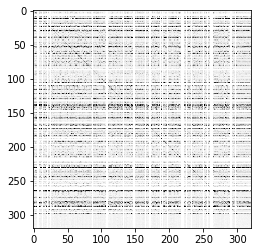

In [128]:
plt.imshow(pCoDraft, cmap="Greys");
print(pCoDraft[0:6,0:6])

array([[0.        , 0.05967078, 0.04973822, 0.04166667, 0.0536193 ],
       [0.08436214, 0.        , 0.125     , 0.07142857, 0.07438017],
       [0.03141361, 0.04166667, 0.        , 0.02247191, 0.04255319],
       [0.17628205, 0.17346939, 0.20224719, 0.        , 0.18987342],
       [0.09651475, 0.08264463, 0.14893617, 0.07594937, 0.        ]])

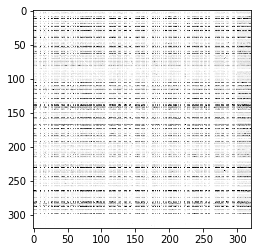

In [129]:
plt.imshow(pChoice, cmap="Greys");
pChoice[0:5,0:5]

In [130]:
pFull[1:19]

array([1656.,  368.,  747.,  501.,  326.,    0.,    0.,    0.,  126.,
        468.,  874.,  134.,    0.,  458.,  338., 1225., 1868.,  251.])

In [131]:
# --- Save everything
np.savetxt('bots_data/bayes_pCoDraft.csv', pCoDraft, delimiter=",")
np.savetxt('bots_data/bayes_pChoice.csv', pChoice, delimiter=",")
np.savetxt('bots_data/bayes_pFull.csv', pFull, delimiter=",")
# Save card names, to match later
pd.DataFrame(nameList['Name']).to_csv('bots_data/bayes_names.csv',index=False)

In [113]:
# Playground for co-occurrence matrix
# Test for denominator. Let's say it's rare, uncommon, common (good-mid-bad)
c = np.zeros([3,3])
c += np.outer(np.array([1,1,1]),np.array([0,0,0]))
c += np.outer(np.array([0,1,1]),np.array([1,0,0]))
c += np.outer(np.array([0,0,1]),np.array([1,1,0]))
print(c.astype(int))
# A_ij means that card i (row) was considered, when card j (column) was already present

[[0 0 0]
 [1 0 0]
 [2 1 0]]


In [111]:
# Playground for preference matrix
c = np.zeros([3,3])
# A_ij counts how many time card i (row) won over card j (column)
# Now let's have some history
c += np.outer(np.array([0,1,0]),np.array([1,1,0])) # 1 won over 0
c += np.outer(np.array([1,0,0]),np.array([1,1,0])) # 0 won over 1
c += np.outer(np.array([0,1,0]),np.array([1,1,0])) # again (2nd time)
c += np.outer(np.array([1,0,0]),np.array([1,1,0]))
c += np.outer(np.array([0,1,0]),np.array([1,1,0])) # 3d time
c += np.outer(np.array([1,0,0]),np.array([1,1,0]))
c += np.outer(np.array([0,1,0]),np.array([1,1,0])) # 4th time
c += np.outer(np.array([1,0,0]),np.array([1,1,0]))
c += np.outer(np.array([0,0,1]),np.array([1,1,1])) # 2 won over both, once
np.fill_diagonal(c,0)
print(c.astype(int))

print(np.matmul(np.log(c+1),np.array([1,1,1])))

[[0 4 0]
 [4 0 0]
 [1 1 0]]
[1.60943791 1.60943791 1.38629436]
